(tropical_profiles)=
# Tropical cloud profiles

This notebook shows how to locate clouds in the tropical_subset.nc netcdf file and plot their temperature and liquid water profiles

## Reading the file

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
the_file = Path.home() / "Dropbox/phil_files/a405/data/tropical_subset.nc"
the_ds = xr.open_dataset(the_file)

### remove the time dimension (only one timestep) using squeeze

In [2]:
print(f"{the_ds['TABS'].shape=}")
the_temp = the_ds['TABS'][...].squeeze()
the_height=the_ds['z'][...].squeeze()
xvals=the_ds['x'][...].squeeze()
yvals=the_ds['y'][...].squeeze()
print(f"{the_height.shape=}")
the_press=the_ds['p'][...].squeeze()
the_press=the_press*100.  #convert to Pa
wvel=the_ds['W'][...].squeeze()  #m/s
qv=the_ds['QV'][...].squeeze()  #vapor g/kg
ql=the_ds['QN'][...].squeeze()  #liquid  g/kg
print(f"{ql.shape=}")

the_ds['TABS'].shape=(1, 112, 110, 100)
the_height.shape=(112,)
ql.shape=(112, 110, 100)


### How much liquid water is in the domain?

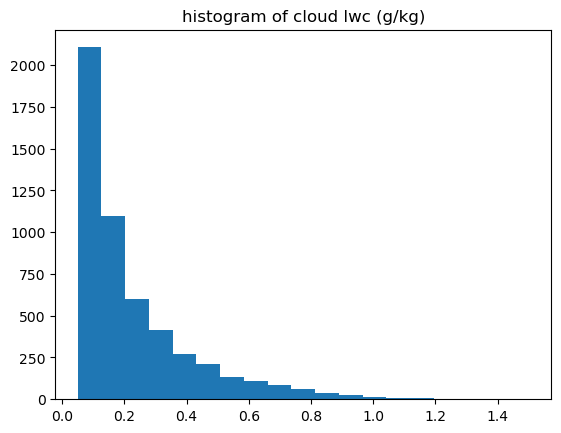

In [3]:
bins=np.linspace(0.05,1.5,20)
out=plt.hist(ql.data.flat,bins=bins)
plt.title('histogram of cloud lwc (g/kg)');

### Temperature and vapor mixing ratio profiles

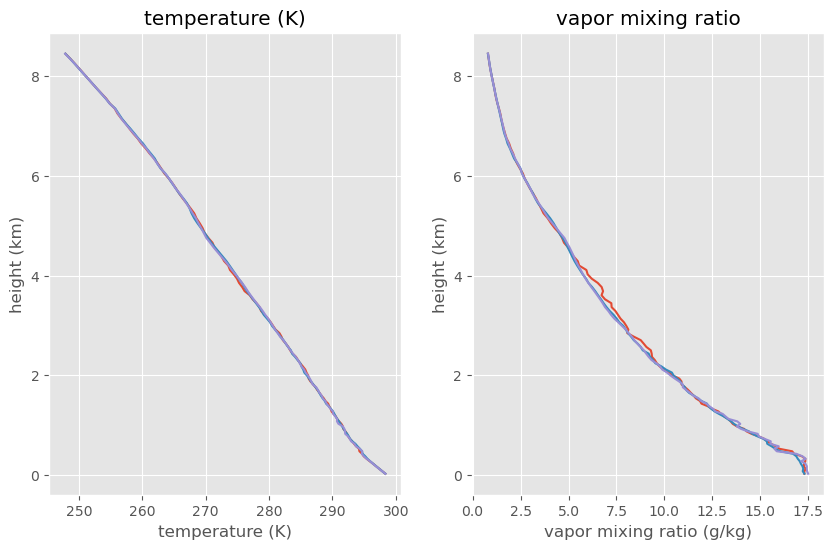

In [4]:
plt.style.use('ggplot')
meter2km=1.e-3
g2kg = 1.e-3
#
# three random columns
#
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,2,figsize=(10,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature (K)')
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='vapor mixing ratio')

### zoom in on bottom 1 km

Note the change in the temperature and water vapor profiles near the surface -- this is atmospheric boundary layer

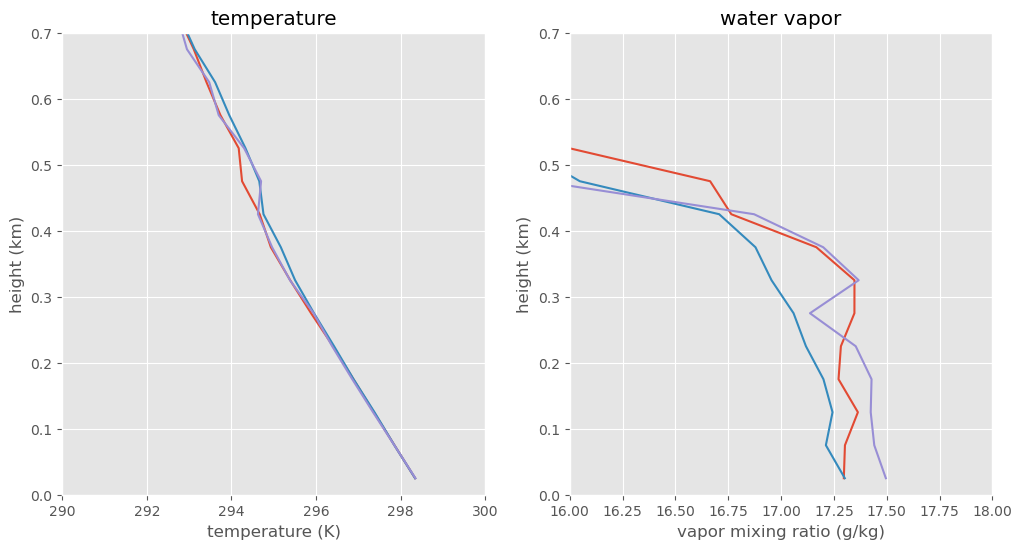

In [5]:
#
# plot 3 arbitrary columns to compare
#
from matplotlib import pyplot as plt
meter2km=1.e-3
lv=2.5e6
g=9.8
cpd=1004.
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,2,figsize=(12,6))
for x,y in random_xy:
    temp_profile=the_temp[:,y, x]
    qv_profile=qv[:,y, x]
    hm_profile = cpd*temp_profile + lv*qv_profile*g2kg + g*the_height
    out=ax[0].plot(temp_profile,the_height*meter2km) 
    out=ax[1].plot(qv_profile,the_height*meter2km) 
out=ax[0].set(xlabel='temperature (K)',ylabel='height (km)',title='temperature')
ax[0].set(xlim=(290,300))
ax[1].set(xlim=(16,18))
out=ax[1].set(xlabel='vapor mixing ratio (g/kg)',ylabel='height (km)',title='water vapor')
for the_ax in ax:
    the_ax.set(ylim=(0,0.7))

## Find the active cloud gridcells at 500 meters

Locate all grid cells near 500 meters with liquid water and find their
vertical velocity.  We want to look at the most bouyant gridcells.

Use searchsorted to find  that the index closest to 500 meters is 10, which puts the height at 525 meters

Use ravel to flatten the x,y grid to one dimension

index_500=10
the_height[index_500].data=array(525., dtype=float32)


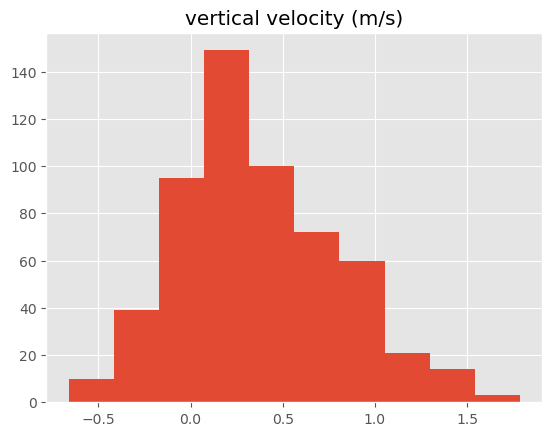

In [6]:
index_500 = np.searchsorted(the_height,500)
print(f"{index_500=}")
print(f"{the_height[index_500].data=}")
hit_cloud_cells_500  = (ql[index_500,:,:] > 0.).data.ravel()
wvel_cloud = wvel[index_500,:,:].data.ravel()
wvel_cloud = wvel_cloud[hit_cloud_cells_500]
plt.hist(wvel_cloud)
ax = plt.gca()
ax.set_title("vertical velocity (m/s)");

### find the x,y coordinates of the strongest updrafts

In [7]:
out = np.where(np.logical_and(ql[index_500,:,:] > 0.,wvel[index_500,:,:]>1.5))
out

(array([41, 50, 55, 76, 93]), array([56, 84, 32, 56, 55]))

### zip the y,x arrays together to get (y,x) pairs

We have two separate vectors, out[0] (y values) and out[1] (xvalues)

Below I use the zip itterator to zipper them together, and the '*' operator (see [this article](https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3) for list and keyword expansion.)

The problem with iterators is that you can only use them once -- see [this stack overflow answer](https://stackoverflow.com/questions/25653996/what-is-the-difference-between-list-and-iterator-in-python#:~:text=A%20list%20is%20a%20data,time%2C%20via%20the%20next%20function.&text=One%20way%20to%20see%20the,iterators%20from%20a%20single%20list.&text=iter%20returns%20an%20iterator.)  Iterators are actually functions, not data structures.  So I "drain the interator" by converting it into a list in case I might need to use it again.

In [8]:
updraft_list =list(zip(*out))

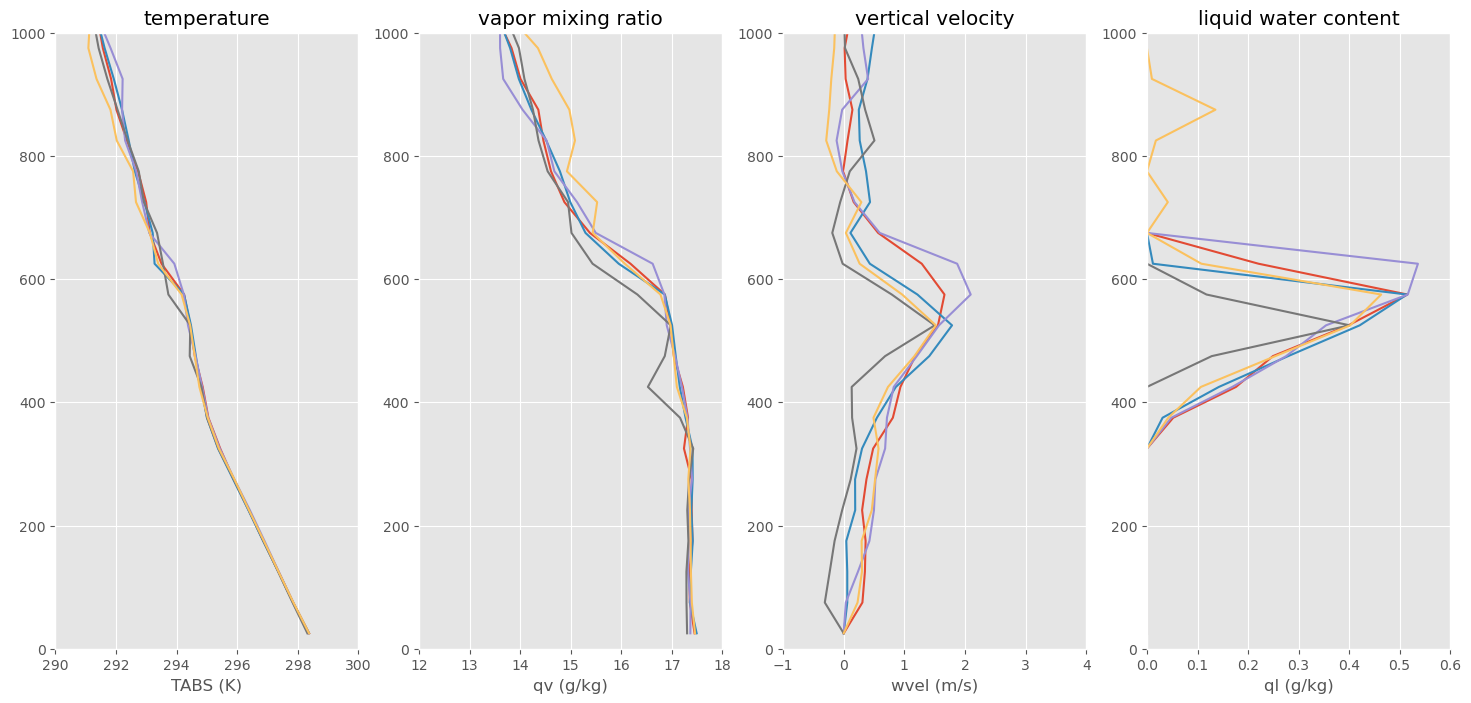

In [9]:
fig,ax=plt.subplots(1,4,figsize=(18,8))
for y,x in updraft_list:
    ax[0].plot(the_temp[:,y,x],the_height)
    ax[1].plot(qv[:,y,x],the_height)
    ax[2].plot(wvel[:,y,x],the_height)
    ax[3].plot(ql[:,y,x],the_height)
ax[0].set(xlim=(290,300),xlabel='TABS (K)',title='temperature')
ax[1].set(xlim=(12,18),xlabel='qv (g/kg)',title='vapor mixing ratio')
ax[2].set(xlim=(-1,4),xlabel='wvel (m/s)',title='vertical velocity')
ax[3].set(xlim=(0,.6),xlabel='ql (g/kg)',title='liquid water content')
out=[the_ax.set(ylim=(0,1000)) for the_ax in ax]